# Colab VGG16 Training

## Get data

In [3]:
import sys
import pathlib
import PIL
import numpy as np
import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import pathlib
import numpy as np
import tensorflow as tf
import keras
from keras.applications import vgg16
import os
import matplotlib.pyplot as plt

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/My Drive/Colab/CS182-Spring2020-Vision-Project")

In [5]:
# os.listdir()

## Uncomment following blocks to download data

In [6]:
# os.chdir("./data")
# os.listdir()

In [7]:
# !chmod +x get_data.sh

In [8]:
# !./get_data.sh

In [9]:
# os.chdir("/content/drive/My Drive/Colab/CS182-Spring2020-Vision-Project")

## Setup

In [10]:
# Create a tensorflow dataset
data_dir = pathlib.Path('./data/tiny-imagenet-200/train/')
image_count = len(list(data_dir.glob('**/*.JPEG')))
print('Discovered {} images'.format(image_count))

Discovered 100000 images


In [11]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

# Simple image preprocessing:  Scale images to [0, 1] float32
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

# Create the training data generator
BATCH_SIZE = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes=list(CLASS_NAMES))

Found 100000 images belonging to 200 classes.


In [12]:
label_dict = {}

In [13]:
with open("./data/tiny-imagenet-200/words.txt", "r") as f:
  i = 0
  for line in f:
    i += 1
    k, v = line.strip().split("\t")
    label_dict[k] = v

In [14]:
image_batch, label_batch = next(train_data_gen)

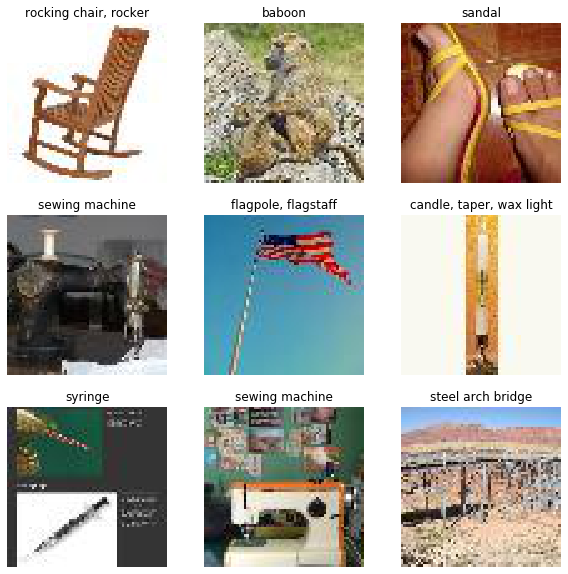

In [15]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_dict[CLASS_NAMES[label_batch[n]==1][0]])
      plt.axis('off')
show_batch(image_batch, label_batch)

In [16]:
base_model = tf.keras.applications.VGG16(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')

In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 512)


In [18]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [20]:
prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 200)


In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [22]:
# base_learning_rate = 0.0001
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', 'top_k_categorical_accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               102600    
Total params: 14,817,288
Trainable params: 102,600
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
len(model.trainable_variables)

2

In [27]:
EPOCHS = 1
from keras.models import load_model
model = load_model("best_vgg16.h5")
for _ in range(EPOCHS):
    model.fit(train_data_gen)

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [26]:
model.save("best_vgg16.h5")

In [0]:
# # Load the classes
# data_dir = pathlib.Path('./data/tiny-imagenet-200/train/')
# CLASSES = sorted([item.name for item in data_dir.glob('*')])

# # Loop through the CSV file and make a prediction for each line
# image_id, image_path, image_height, image_width, image_channels = \
#   "0 data/tiny-imagenet-200/val/images/val_15.JPEG 64 64 3".split(" ")

# print(image_id, image_path, image_height, image_width, image_channels)

# # Preprocess our data
# image_data = image.img_to_array(image.load_img(image_path, target_size=(224, 224)))
# preprocessed_image_data = image_data / 255.0

# # Generate a prediction
# prediction_probs = model.predict(np.expand_dims(preprocessed_image_data, 0))
# prediction = int(np.argmax(prediction_probs.reshape(-1)))

# # Write the prediction to the output file
# print(image_id, prediction)

0 data/tiny-imagenet-200/val/images/val_15.JPEG 64 64 3
0 669


In [0]:
# with open('./eval.csv', 'r') as eval_output_file:  # Open the evaluation CSV file for writing
#   for line in eval_output_file:
#     print(line.strip().split(','))

In [0]:
# !chmod +r eval.csv

In [0]:
# data_dir = pathlib.Path('./data/tiny-imagenet-200/val/')
# val_image_count = len(list(data_dir.glob('**/*.JPEG')))
# print('Discovered {} images'.format(val_image_count))
# train_data_gen = image_generator.flow_from_directory(directory=str(val_dir),
#                                                       batch_size=BATCH_SIZE,
#                                                       shuffle=True,
#                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                       classes=list(CLASS_NAMES))

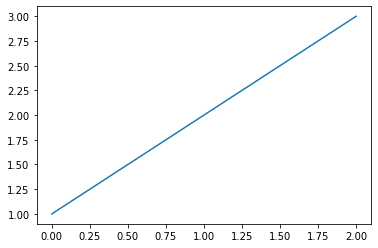

In [2]:
plt.plot([1,2,3])